In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

from xgboost import XGBClassifier, XGBRegressor, plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

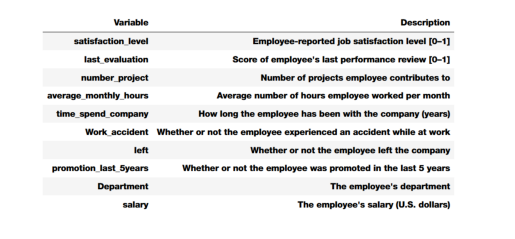

In [2]:
import matplotlib.image as mpimg

data_dictionary = mpimg.imread('/content/drive/MyDrive/Screenshot 2025-08-24 144329.png')

plt.imshow(data_dictionary)
plt.axis('off')
plt.show()

In [3]:
path = "/content/drive/MyDrive/HR_comma_sep.csv"
data = pd.read_csv(path)

data.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


In [4]:
data.isnull().sum()

,0
satisfaction_level,0
last_evaluation,0
number_project,0
average_montly_hours,0
time_spend_company,0
Work_accident,0
left,0
promotion_last_5years,0
Department,0
salary,0


In [5]:
df1 = data.drop_duplicates(keep='first')

print(data.shape[0] - df1.shape[1])

14989


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11991 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     11991 non-null  float64
 1   last_evaluation        11991 non-null  float64
 2   number_project         11991 non-null  int64  
 3   average_montly_hours   11991 non-null  int64  
 4   time_spend_company     11991 non-null  int64  
 5   Work_accident          11991 non-null  int64  
 6   left                   11991 non-null  int64  
 7   promotion_last_5years  11991 non-null  int64  
 8   Department             11991 non-null  object 
 9   salary                 11991 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.0+ MB


In [7]:
df1 = df1.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department'})

df1.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [8]:
target_dist = df1['left'].value_counts()

target_dist.values

array([10000,  1991])

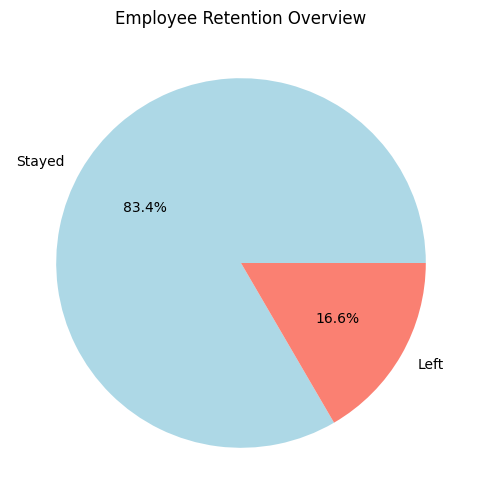

In [9]:
plt.figure(figsize=(6,6))
plt.pie(target_dist.values, labels=['Stayed','Left'], autopct='%1.1f%%', colors=['lightblue', 'salmon'])
plt.title('Employee Retention Overview')
plt.show()

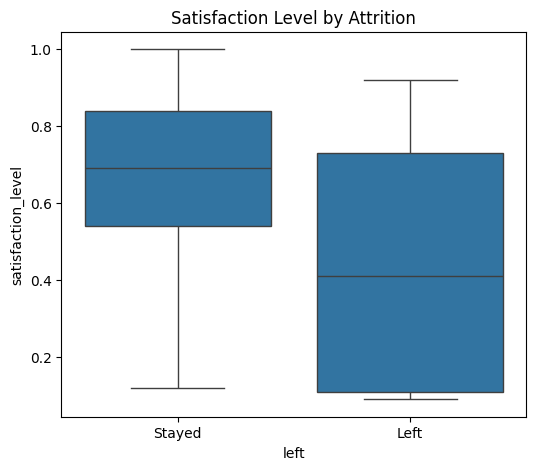

In [10]:
plt.figure(figsize=(6,5))
sns.boxplot(data=df1, x='left', y='satisfaction_level')
plt.title('Satisfaction Level by Attrition')
plt.xticks([0,1],['Stayed','Left'])
plt.show()

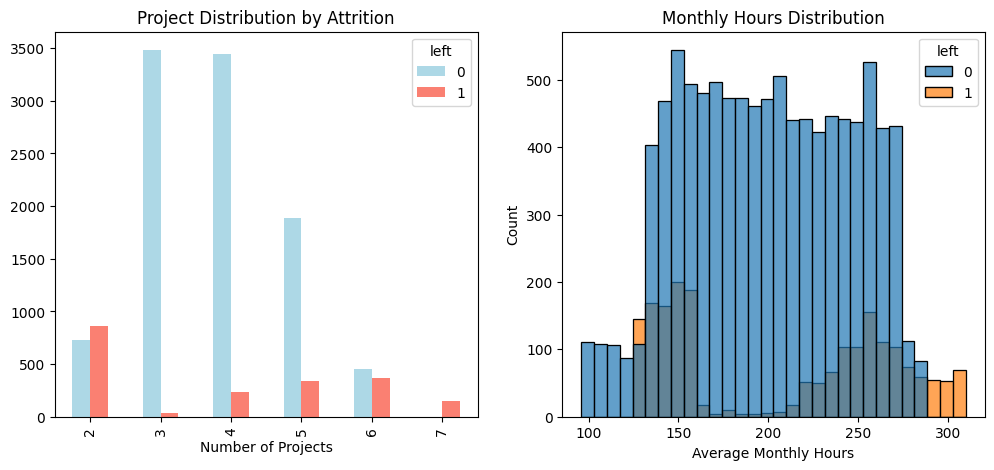

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

#Visualizing the number of projects by attrition
projects = df1.groupby(['number_project','left']).size().unstack()

projects.plot(kind='bar', color=['lightblue','salmon'],ax=ax[0])
ax[0].set_title('Project Distribution by Attrition')
ax[0].set_xlabel('Number of Projects')

#Monthly hours distribution
sns.histplot(data=df1, x='average_monthly_hours', hue='left', ax=ax[1], bins=30, alpha=0.7)
ax[1].set_title("Monthly Hours Distribution")
ax[1].set_xlabel("Average Monthly Hours")
plt.show()

The organization should investigate why some employees work extreme hours and some are underutilized. From the above two graphs, the 'sweet spot' appears to be 150-220 monthly hours while managing 3-4 projects where the retention rate is at its highest. Both overwork and underwork appear to contribute to turnover


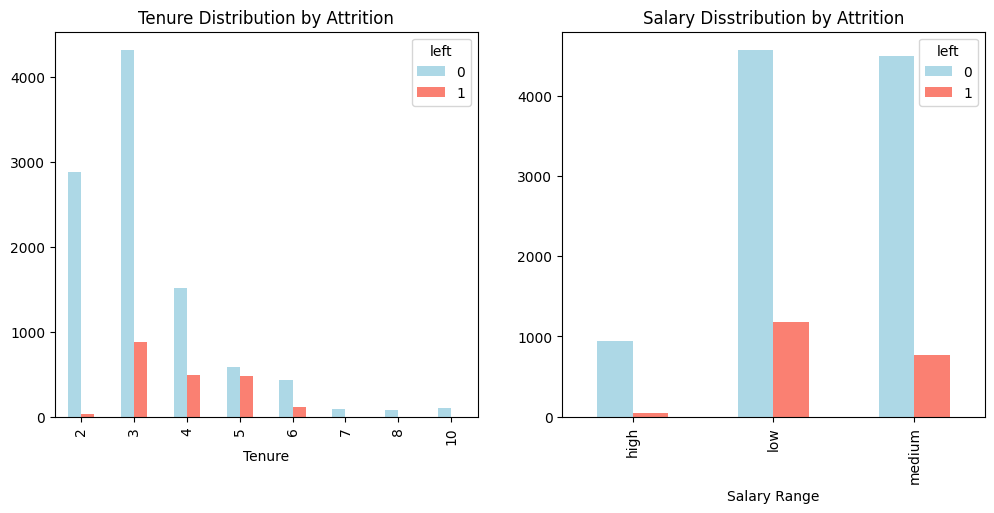

In [12]:
#Tenure Distribution
tenure = df1.groupby(['tenure', 'left']).size().unstack(fill_value=0)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
tenure.plot(kind='bar', color=['lightblue', 'salmon'],ax=ax[0])
ax[0].set_xlabel("Tenure")
ax[0].set_title("Tenure Distribution by Attrition")

#Salary Distribution
salary = df1.groupby(['salary','left']).size().unstack()

salary.plot(kind='bar', color=['lightblue','salmon'], ax=ax[1])
ax[1].set_title("Salary Disstribution by Attrition")
ax[1].set_xlabel("Salary Range")
plt.show()

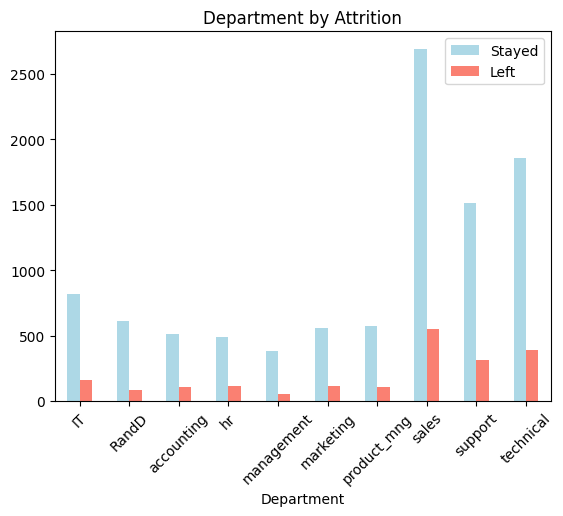

In [13]:
department = df1.groupby(['department','left']).size().unstack()

department.plot(kind='bar', color=['lightblue','salmon'])
plt.title('Department by Attrition')
plt.xlabel('Department')
plt.legend(['Stayed', 'Left'])
plt.xticks(rotation=45)
plt.show()

In [20]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11991 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     11991 non-null  float64
 1   last_evaluation        11991 non-null  float64
 2   number_project         11991 non-null  int64  
 3   average_monthly_hours  11991 non-null  int64  
 4   tenure                 11991 non-null  int64  
 5   work_accident          11991 non-null  int64  
 6   left                   11991 non-null  int64  
 7   promotion_last_5years  11991 non-null  int64  
 8   department             11991 non-null  object 
 9   salary                 11991 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.0+ MB


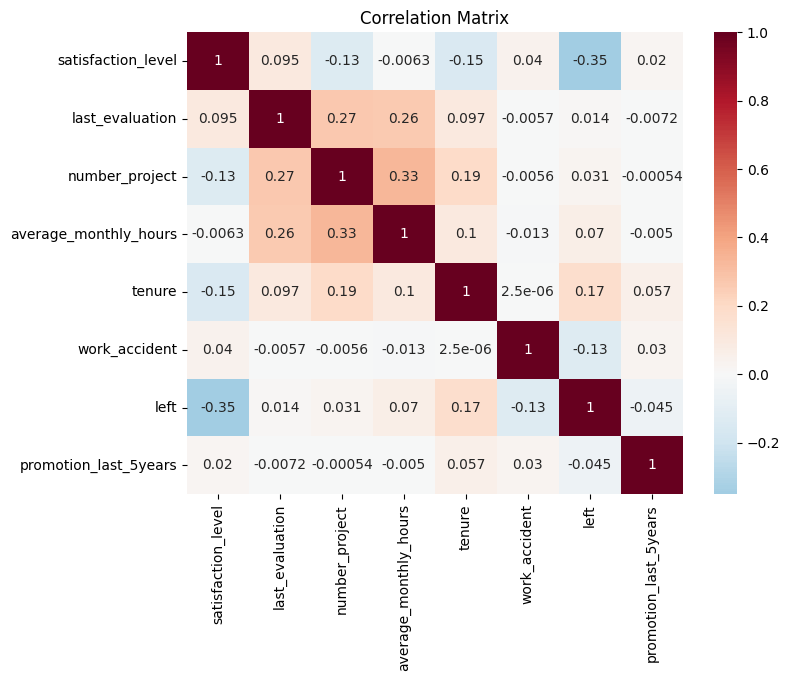

In [23]:
num_col = ['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left','promotion_last_5years']

corr_matrix = df1[num_col].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.title("Correlation Matrix")
plt.show()